Let's now try more deep architectures to solve the same problem. To enable that, use batchnorm and initialize the weights of the model properly.

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Use CUDA if possible
model_device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# The same dataset
names = open("../names.txt", "r").read().splitlines()

# convert index to character
itoc = list(set(list(''.join(names))))
itoc.sort()
itoc = ['.'] + itoc

# convert character to index
ctoi = {itoc[i] : i for i in range(len(itoc))}

# Data consts
alph_size = len(itoc)

names[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
# Train, dev, test splits
import random
random.seed(27)

random.shuffle(names)
train_size = int(0.8 * len(names))
dev_size = int(0.1 * len(names))

train_set = names[:train_size]
dev_set = names[train_size:train_size + dev_size]
test_set = names[train_size + dev_size:]
print(len(train_set), len(dev_set), len(test_set))

25626 3203 3204


In [5]:
# Hyperparams

h_context_size = 6
h_emb_dim = 8
h_hidden_sizes = [50, 50, 50, 50, 50] # linear+tanh -like layers
h_batch_size = 40
h_use_batchnorm = True

In [6]:
# Encode data for chosen architecture
def build_dataset(raw):
    X = []
    Y = []
    for word in raw: # for demonstration
        # print(word)
        context = [0] * h_context_size
        for ch in word + '.':
            X.append(context)
            Y.append(ctoi[ch])
            # print(''.join([itoc[i] for i in context]), '-->', ch)
            context = context[1:] + [ctoi[ch]]
    return torch.tensor(X), torch.tensor(Y)

X_tr, Y_tr = build_dataset(train_set)
X_dev, Y_dev = build_dataset(dev_set)
X_test, Y_test = build_dataset(test_set)
X_tr.shape, Y_tr.shape

(torch.Size([182351, 6]), torch.Size([182351]))

In [7]:
# Implement our model's modules in Pytorch API style

class Module:
    def __init__(self):
        self.training = True # see torch.nn.Module

    def __repr__(self):
        return self.__str__()

class Linear(Module):
    def __init__(self, fan_in, fan_out, bias=True, device=None):
        super().__init__()
        self.weight = torch.randn((fan_in, fan_out), device=device) / (fan_in ** 0.5) # 'Kaiming init', to preserve Gaussian-like distribution of input on initialization
        self.bias = torch.zeros((fan_out,), device=device) if bias else None

    def __call__(self, input):
        if self.bias == None:
            return input @ self.weight
        else:
            return input @ self.weight + self.bias

    def get_params(self):
        if self.bias == None:
            return [self.weight]
        else:
            return [self.weight, self.bias]

    def __str__(self):
        return "Linear"

class Tanh(Module):
    def __init__(self):
        super().__init__()
    
    def __call__(self, input):
        return torch.tanh(input)

    def get_params(self):
        return []

    def __str__(self):
        return "Tanh"

class BatchNorm1D(Module):
    def __init__(self, size, eps=1e-05, momentum=0.1, device=None):
        super().__init__()
        self.eps = eps
        self.momentum = momentum
        self.gamma = torch.randn((size,), device=device)
        self.beta = torch.zeros((size,), device=device)
        self.running_mean = torch.zeros((size,), device=device)
        self.running_var = torch.ones((size,), device=device)

    def __call__(self, input):
        if self.training == False:
            out = None
            with torch.no_grad():
                out = ((input - self.running_mean) / torch.sqrt(self.running_var + self.eps)) * self.gamma + self.beta
            return out
        
        batch_mean = input.mean(0, keepdim=True)
        batch_var = input.var(0, keepdim=True)
        with torch.no_grad():
            self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * batch_mean
            self.running_var = (1 - self.momentum) * self.running_var + self.momentum * batch_var
        return ((input - batch_mean) / torch.sqrt(batch_var + self.eps)) * self.gamma + self.beta            

    def get_params(self):
        return [self.gamma, self.beta]

    def __str__(self):
        return "BatchNorm1D"

In [8]:
# Initialzie the model

# init hparams
init_gain = 5.0 # 5/3 # to make tanh output Gaussian
init_last_factor = 0.1 # to make initial distribution uniform-like to meet our intuition of untrained model

C = torch.randn((alph_size, h_emb_dim), device=model_device)
layers = [ 
    [Linear(fan_in, fan_out, bias=not h_use_batchnorm, device=model_device)] + 
    ([BatchNorm1D(fan_out, device=model_device)] if h_use_batchnorm else []) + 
    [Tanh()]
    for (fan_in, fan_out) in zip([h_emb_dim * h_context_size] + h_hidden_sizes, h_hidden_sizes + [alph_size])
]
layers = sum(layers, [])[:-1] # discard the last tanh layer
print(layers) # Net architecture
params = sum([l.get_params() for l in layers], [C])
print(sum([param.nelement() for param in params])) # Model size

with torch.no_grad(): # init, no gradient needed
    linear_layers = list(filter(lambda x : isinstance(x, Linear), layers))
    for layer in linear_layers[:-1]: # all linear layers followed by tanh
        layer.weight *= init_gain
    if h_use_batchnorm:
        layers[-1].gamma *= init_last_factor # last layer is batchnorm
    else:
        layers[-1].weight *= init_last_factor # last layer is linear

[Linear, BatchNorm1D, Tanh, Linear, BatchNorm1D, Tanh, Linear, BatchNorm1D, Tanh, Linear, BatchNorm1D, Tanh, Linear, BatchNorm1D, Tanh, Linear, BatchNorm1D]
14520


In [9]:
def sample_batch(X, Y):
    ind = torch.randint(0, X.shape[0], (h_batch_size,))
    return X[ind].to(model_device), Y[ind].to(model_device)

def embed(examples):
    return C[examples].view(examples.shape[0], -1)

def forward(X):
    current = embed(X)
    for layer in layers:
        current = layer(current)
    return current

def reset_grad():
    for param in params:
        param.grad = None

def update(lr):
    for param in params:
        param.data -= lr * param.grad

@torch.no_grad()
def get_upd_scale(lr):
    # return [((lr * p.grad).std() / p.std()).log10().item() for p in params]
    return [((lr * p.grad).abs().mean() / p.abs().mean()).log10().item() for p in params]

def train_mode():
    for param in params:
        param.requires_grad = True
    for layer in layers:
        layer.training = True

def collect_outs():
    train_mode()
    outs = []
    X_b, Y_b = sample_batch(X_tr, Y_tr)
    current = embed(X_b)
    for layer in layers: # forward pass with keeping activations
        current = layer(current)
        current.retain_grad() # keep gradients also
        outs.append(current)
    loss = F.cross_entropy(current, Y_b)
    reset_grad()
    loss.backward() # calculate gradients, no update
    return outs

def train(iter, lr, collect_stats=False):
    train_mode()
    lossi = []
    upd_scale = []
    for i in range(iter):
        X_b, Y_b = sample_batch(X_tr, Y_tr)
        loss = F.cross_entropy(forward(X_b), Y_b)
        if i % (iter / 10) == 0:
            print(f'{i} / {iter}; loss: {loss.item()}')
        reset_grad()
        loss.backward()
        if collect_stats:
            lossi.append(loss.item())
            upd_scale.append(get_upd_scale(lr))
        update(lr)
    if collect_stats:
        return lossi, upd_scale

def eval_mode():
    for param in params:
        param.requires_grad = False
    for layer in layers:
        layer.training = False

def eval(split_name):
    eval_mode()
    X, Y = {
        'train' : (X_tr,   Y_tr),
        'dev'   : (X_dev,  Y_dev),
        'test'  : (X_test, Y_test)
    }[split_name]
    return F.cross_entropy(forward(X), Y).item()

In [10]:
# Train the model, collect statistics
lossi, upd_scale = train(10000, 0.25, collect_stats=True)
outs = collect_outs()
print("train loss:", eval('train'), "; val loss:", eval('dev'))

0 / 10000; loss: 3.31288480758667
1000 / 10000; loss: 2.473174571990967
2000 / 10000; loss: 2.182267427444458
3000 / 10000; loss: 2.03686261177063
4000 / 10000; loss: 2.3555636405944824
5000 / 10000; loss: 2.5735716819763184
6000 / 10000; loss: 2.138052225112915
7000 / 10000; loss: 2.078463554382324
8000 / 10000; loss: 2.126451015472412
9000 / 10000; loss: 2.398047924041748
train loss: 2.2165017127990723 ; val loss: 2.2234368324279785


### 'Snapshot' statistics

In [11]:
def visualize(data, name, funcs, precision=None):
    vals, bins = torch.histogram(data, density=True)
    plt.plot(bins[:-1].detach(), vals.detach()) # 'bins' contains bins edges
    if name is not None:
        print(name, end = '; ')
    for func_name, func in funcs.items():
        if precision is None:
            print(f'{func_name}: {func(data)}', end = '; ')
        else:
            print(f'{func_name}: %.{precision}f' % func(data), end = '; ')
    print()

layer 2 : Tanh; mean: -0.05; std: 0.50; saturation: 2.55; 
layer 5 : Tanh; mean: -0.03; std: 0.58; saturation: 3.75; 
layer 8 : Tanh; mean: 0.03; std: 0.55; saturation: 3.10; 
layer 11 : Tanh; mean: 0.02; std: 0.63; saturation: 7.90; 
layer 14 : Tanh; mean: 0.01; std: 0.67; saturation: 11.80; 


Text(0.5, 1.0, 'activations on batch of size 40')

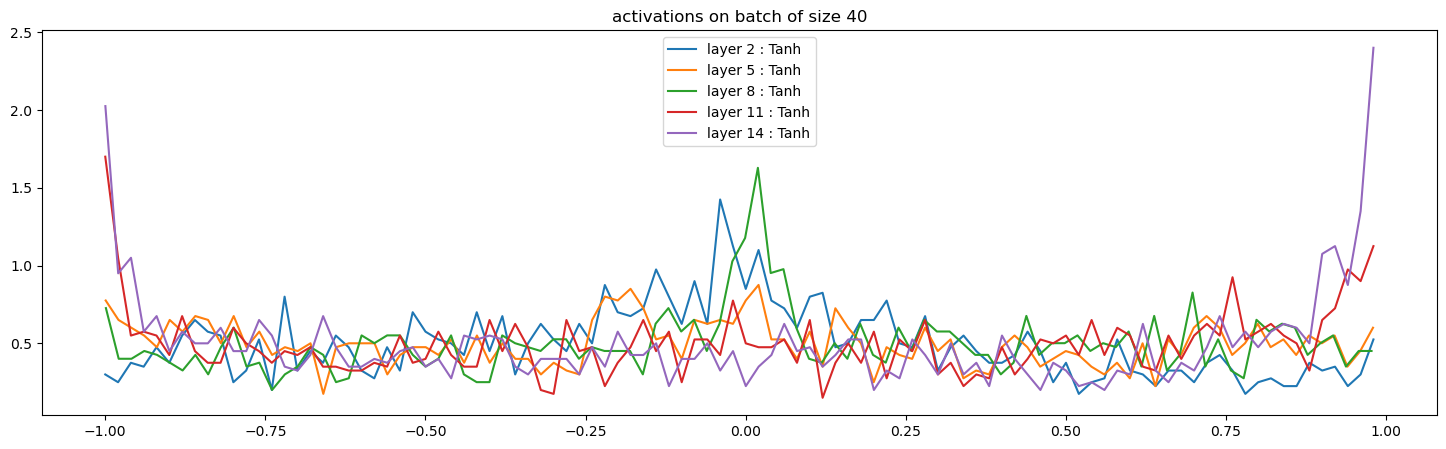

In [12]:
# Visualize tanh activations
# We expect the distributions to be roughly uniform, with low (5-8%) saturation

plt.figure(figsize=(18, 5))
legend = []
for i, (layer, out) in enumerate(zip(layers, outs)):
    if isinstance(layer, Tanh):
        name = f'layer {i} : {layer.__class__.__name__}'
        visualize(out, name, 
                  {'mean' : (lambda x : x.mean().round(decimals=3)), 
                   'std' : (lambda x : x.std().round(decimals=3)), 
                   'saturation' : (lambda x : (x.abs() >= 0.97).float().mean() * 100)},
                  precision=2
        )
        legend.append(name)
plt.legend(legend)
plt.title(f'activations on batch of size {h_batch_size}')

layer 2 : Tanh; mean: 0.0000; std: 0.0050; 
layer 5 : Tanh; mean: -0.0000; std: 0.0050; 
layer 8 : Tanh; mean: 0.0000; std: 0.0050; 
layer 11 : Tanh; mean: -0.0000; std: 0.0040; 
layer 14 : Tanh; mean: -0.0000; std: 0.0040; 


Text(0.5, 1.0, 'activations gradients on batch of size 40')

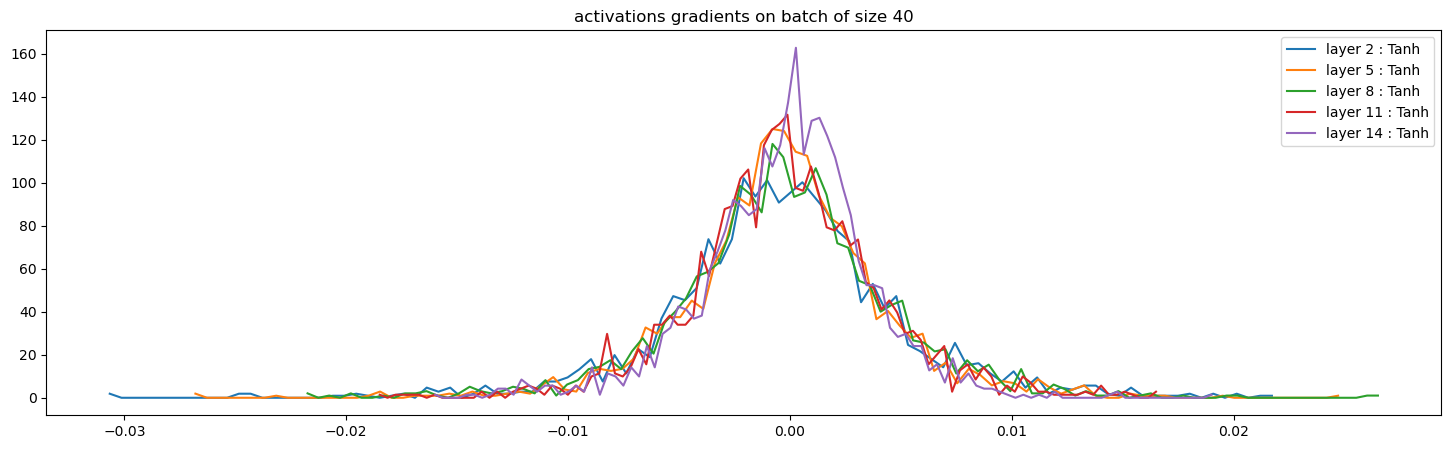

In [13]:
# Visualize tanh activations' gradients
# We expect them to be (roughly) Gaussian and (!!!) equal
# Otherwise we suspect distribution squashing/stretching in the forward pass

plt.figure(figsize=(18, 5))
legend = []
for i, (layer, out) in enumerate(zip(layers, outs)):
    if isinstance(layer, Tanh):
        name = f'layer {i} : {layer.__class__.__name__}'
        visualize(out.grad, name, 
                  {'mean' : (lambda x : x.mean().round(decimals=3)), 
                   'std' : (lambda x : x.std().round(decimals=3))},
                  precision=4
        )
        legend.append(name)

plt.legend(legend)
plt.title(f'activations gradients on batch of size {h_batch_size}')

layer 0 : Linear; mean: 0.007000000216066837; std: 0.7310000061988831; 
layer 3 : Linear; mean: 0.013000000268220901; std: 0.7099999785423279; 
layer 6 : Linear; mean: -0.0010000000474974513; std: 0.7179999947547913; 
layer 9 : Linear; mean: 0.014000000432133675; std: 0.7070000171661377; 
layer 12 : Linear; mean: -0.004999999888241291; std: 0.6940000057220459; 
layer 15 : Linear; mean: -0.007000000216066837; std: 0.2770000100135803; 


Text(0.5, 1.0, 'weights')

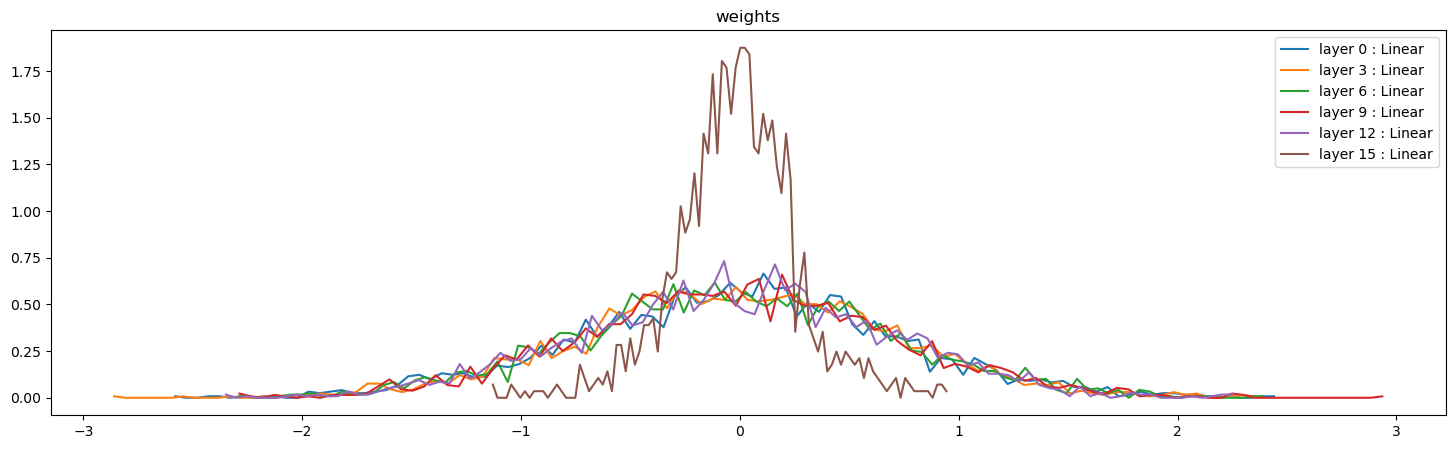

In [14]:
# Visualize weights (actually, not very informative, just to make sure they do not explode)

plt.figure(figsize=(18, 5))
legend = []
for i, layer in enumerate(layers):
    if isinstance(layer, Linear):
        W = layer.weight
        name = f'layer {i} : {layer.__class__.__name__}'
        visualize(W, name,
                 {'mean' : (lambda x : x.mean().round(decimals=3)), 
                   'std' : (lambda x : x.std().round(decimals=3))}
        )
        legend.append(name)
plt.legend(legend)
plt.title(f'weights')

layer 0 : Linear; mean: 0.0; std: 0.003000000026077032; 
layer 3 : Linear; mean: -0.0; std: 0.003000000026077032; 
layer 6 : Linear; mean: -0.0; std: 0.003000000026077032; 
layer 9 : Linear; mean: 0.0; std: 0.003000000026077032; 
layer 12 : Linear; mean: 0.0; std: 0.003000000026077032; 
layer 15 : Linear; mean: 0.0; std: 0.00800000037997961; 


Text(0.5, 1.0, 'weights gradients on batch of size 40')

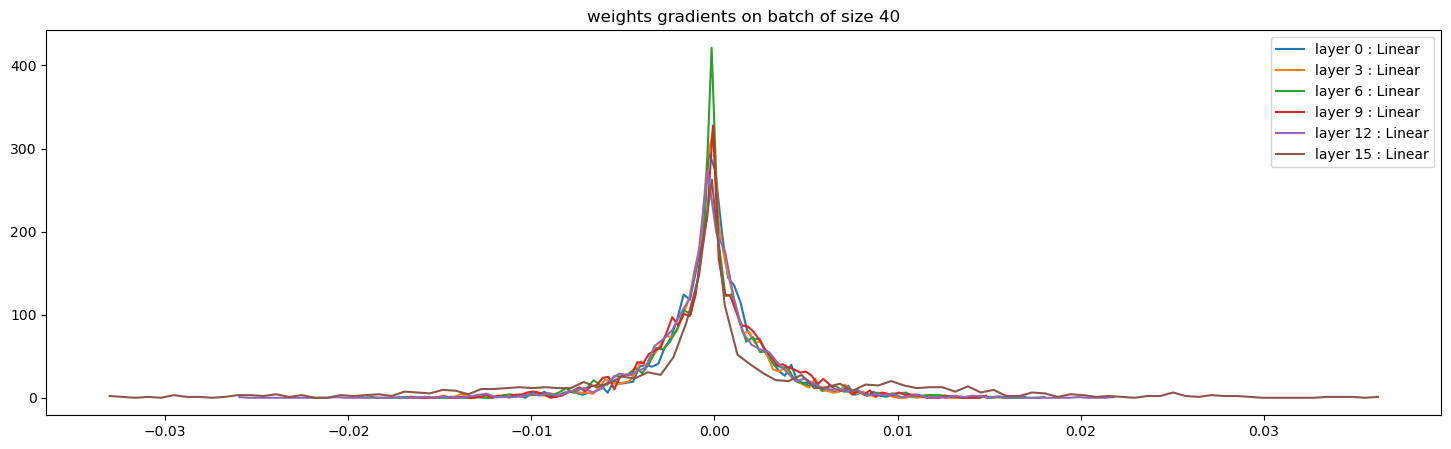

In [15]:
# Visualize weights' gradients
# We expect roughly Gaussian distribution, with no clear trend of gradient growth with increasing layer number

plt.figure(figsize=(18, 5))
legend = []
for i, layer in enumerate(layers):
    if isinstance(layer, Linear):
        W = layer.weight
        name = f'layer {i} : {layer.__class__.__name__}'
        visualize(W.grad, name,
                 {'mean' : (lambda x : x.mean().round(decimals=3)), 
                   'std' : (lambda x : x.std().round(decimals=3))}
        )
        legend.append(name)
plt.legend(legend)
plt.title(f'weights gradients on batch of size {h_batch_size}')

### 'Continuous' statistics

In [16]:
def moving_average(data, window_size):
    window = torch.ones((window_size,)) / window_size;
    return np.convolve(data, window, 'same')

def trim(list, offset):
    return list[offset:-offset]

def plot_smooth(X, Y, smoothing_factor=0.05):
    avg_window_size = int(smoothing_factor * len(X))
    plt.plot(trim(X, avg_window_size), trim(Y, avg_window_size))
    plt.plot(trim(X, avg_window_size), trim(moving_average(Y, avg_window_size), avg_window_size))

Text(0.5, 1.0, 'train loss')

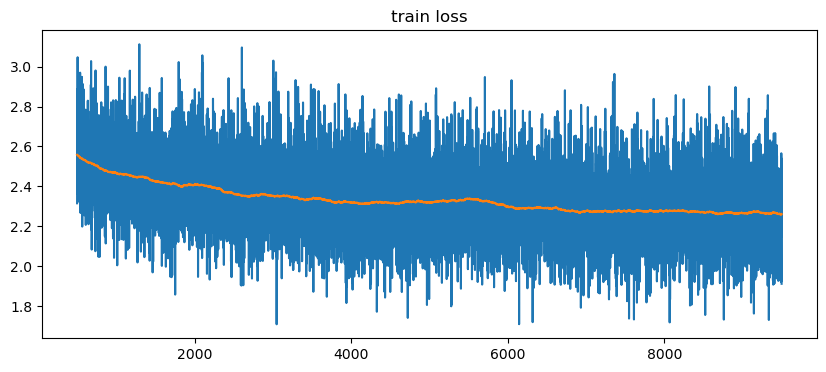

In [17]:
plt.figure(figsize=(10, 4))
plot_smooth(torch.arange(len(lossi)), lossi)
plt.title(f'train loss')

In [18]:
# Some preprocessing
iter = len(upd_scale)
upd_scale = torch.tensor(upd_scale).transpose(0, 1).tolist()

Text(0.5, 1.0, 'weight update scale dynamics')

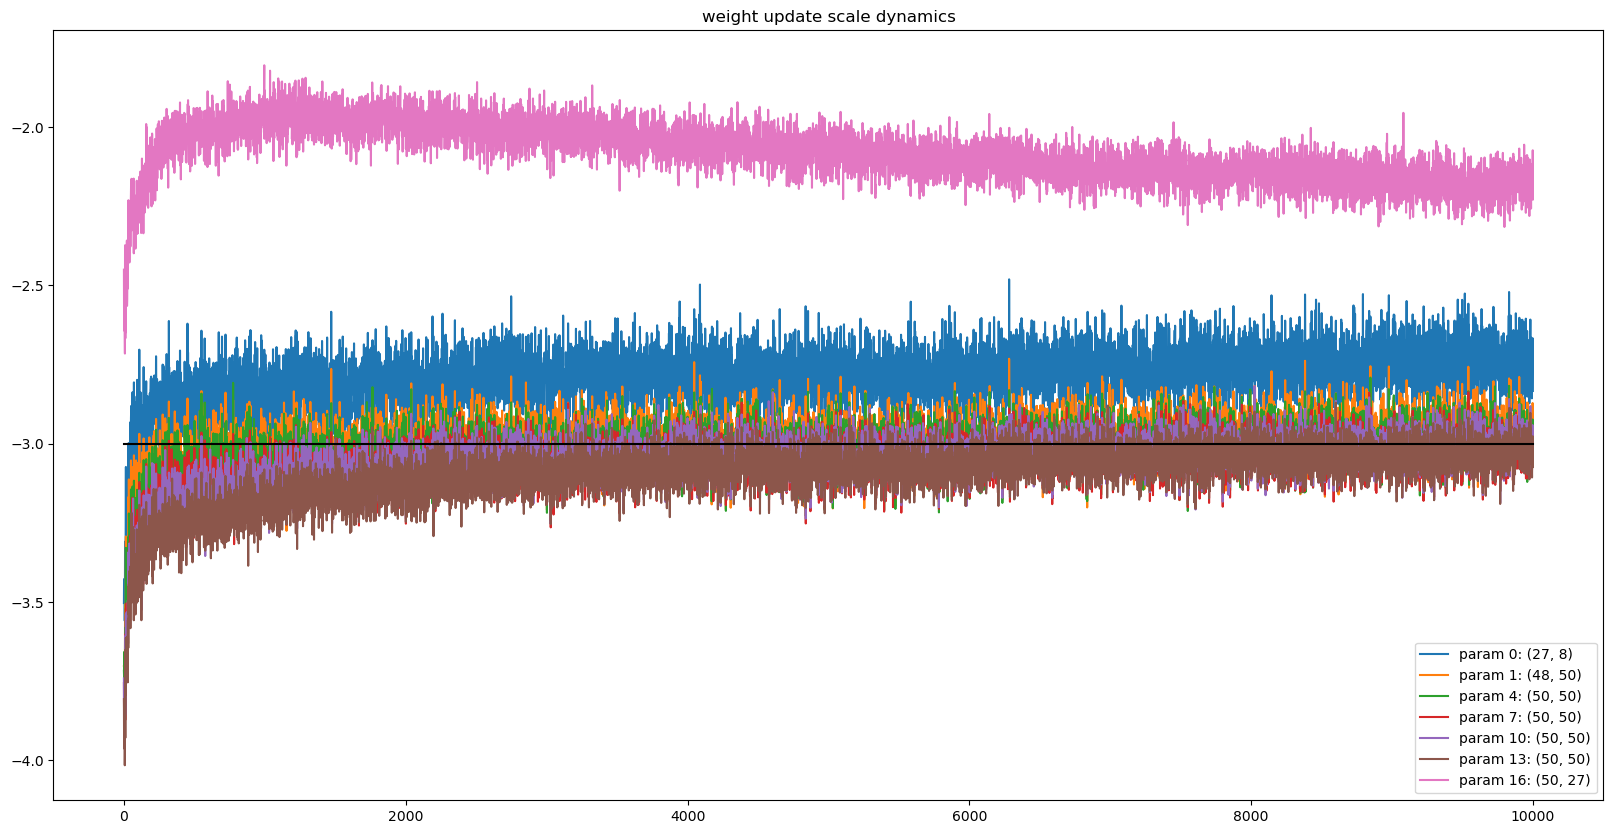

In [19]:
# Visualize weight update scale
# It allows us to estimate how large is the scale of update w.r.t. the scale of actual param values
# to find the optimal learning rate

plt.figure(figsize=(20, 10))
legend = []
for i, param_stats in filter(lambda x: params[x[0]].ndim == 2, enumerate(upd_scale)):
    plt.plot(torch.arange(iter), param_stats)
    legend.append(f'param {i}: {tuple(params[i].shape)}')
plt.plot([0, iter], [-3, -3], 'k') # recommended value
plt.legend(legend)
plt.title('weight update scale dynamics')

Text(0.5, 1.0, 'bias update scale dynamics')

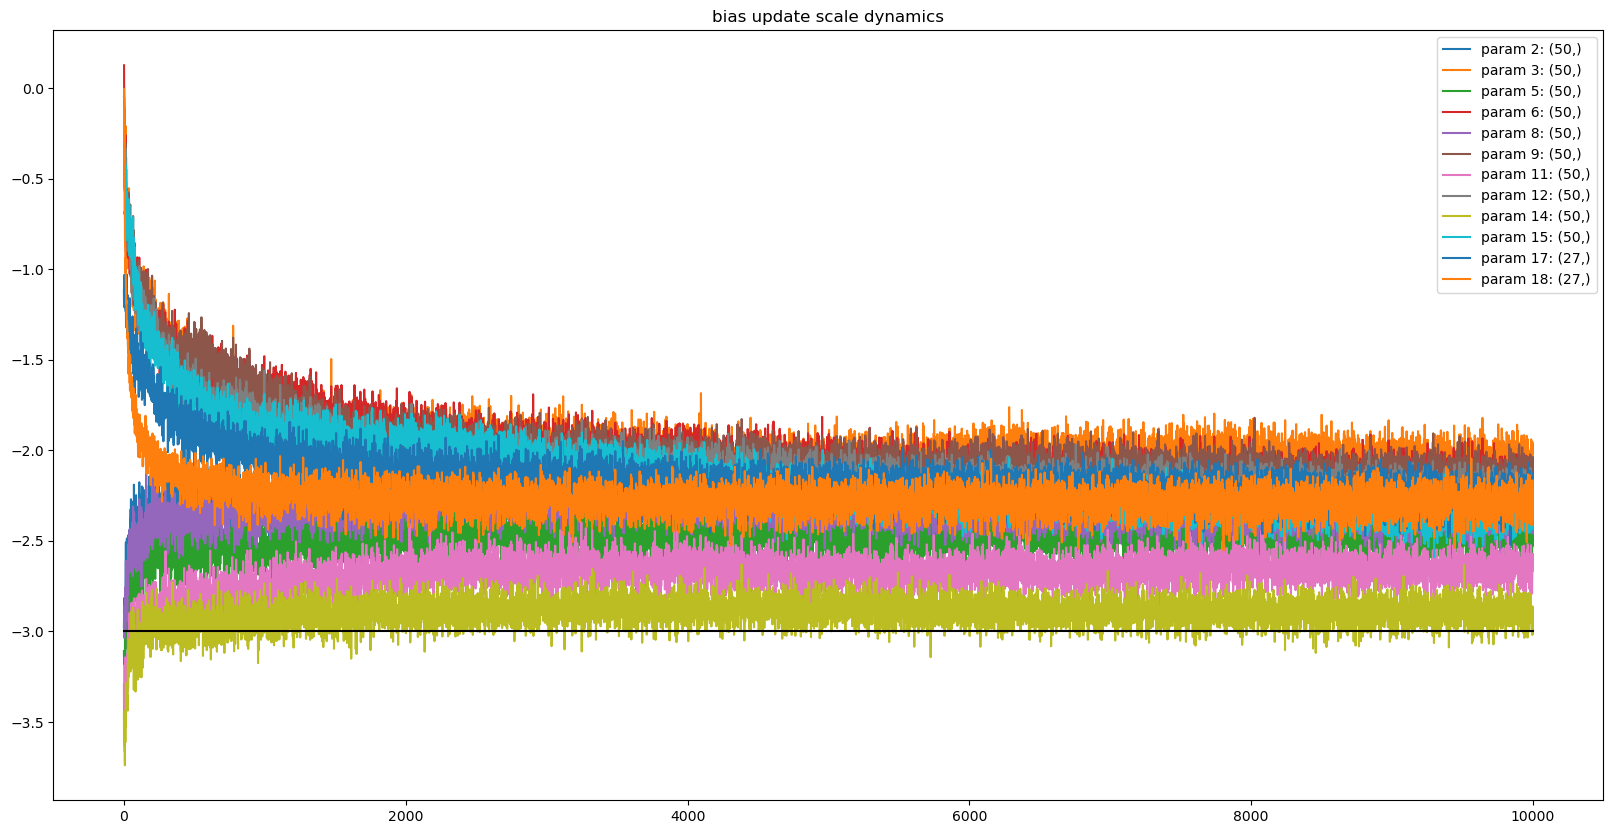

In [20]:
# Visualize bias update scale

plt.figure(figsize=(20, 10))
legend = []
for i, param_stats in filter(lambda x: params[x[0]].ndim == 1, enumerate(upd_scale)):
    plt.plot(torch.arange(iter), param_stats)
    legend.append(f'param {i}: {tuple(params[i].shape)}')
plt.plot([0, iter], [-3, -3], 'k') # recommended value
plt.legend(legend)
plt.title('bias update scale dynamics')